<a href="https://colab.research.google.com/github/clerintom/VISUAL-FEATURE-ENHANCED-TOUR-RECOMMENDER-SYSTEM/blob/main/Visual_Feature_Enhanced_Tour_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Feature Enhanced Tour Recommender System


The goal of this experiment is to make a very basic recommender system: for a given tourist, we want to recommend places that look similar. 


## How to proceed ?

We will used a pre-trained CNN model from Keras to extract the image features.

Then we will compute similarities between the different places using the previously extracted image features.

Other type of information can be used for this purpose such as the image size, color, etc. if the data is available, but that is not the case here.

## 1. imports and parameters setup

In [ ]:
# imports

from keras.applications import vgg16
from tensorflow.keras.utils  import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# parameters setup

#imgs_path = "../input/style/"
imgs_path = '/content/drive/MyDrive/style/'
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similar images to retrieve

## 1. load the VGG pre-trained model from Keras

Keras module contains several pre-trained models that can be loaded very easily. 

For our recommender system based on visual similarity, we need to load a Convolutional Neural Network (CNN) that will be able to interpret the image contents.

In this example we will load the VGG16 model trained on imagenet, a big labeled images database.

If we take the whole model, we will get an output containing probabilities to belong to certain classes, but that is not what we want.

We want to retrieve all the information that the model was able to get in the images.

In order to do so, we have to remove the last layers of the CNN which are only used for classes predictions.

In [ ]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

## 2. get the images paths

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if 'png'or 'jpeg' or 'jpg' in x]

print("number of images:",len(files))

number of images: 444


## 3. feed one image into the CNN

First we observe what output we get when putting one image into the CNN.

The following steps are:
- loading the image
- preparing the image to feed it into the CNN
- get the CNN output which will correspond to the image features

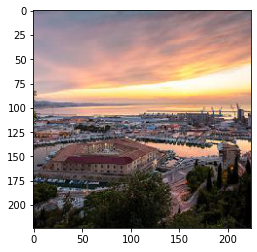

image loaded successfully!


In [ ]:
# load an image in PIL format
original = load_img(files[45], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [ ]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [ ]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 8s 8s/step
features successfully extracted!
number of image features: 4096


array([[2.834022 , 3.7868931, 1.6717242, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

## 4. feed all the images into the CNN

We were able to do the feature extraction process for one image. Now let's do it for all our images!

In [ ]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())


In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

14/14 [==============================] - 7s 322ms/step
features successfully extracted!


(444, 4096)

# 5. compute cosine similarities

Now that we have features for every image, we can compute similarity metrics between every image couple.

We will use here the cosine similarity metric.

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/drive/MyDrive/style/travel-1ea7d845f35751269d8f60d036b9691d3b27928d069c535654b1430c3b7adb62.jpg,/content/drive/MyDrive/style/travel-1f32cca30eae8309eba030a84ad8be4a9f8fc89c3036905f8bd7972d5591779e.jpg,/content/drive/MyDrive/style/travel-1ef464f1ef50fc2aa23e1722e396928d829a428c3f3a1816b39ea5f9bddbcd3a.jpg,/content/drive/MyDrive/style/travel-02e61af356d2982442a1f7306b3eb789d3847b1ac90831aeb9873ca783b3c173.jpg,/content/drive/MyDrive/style/travel-1ec576d457a27d482d86baa1d76317f106f1f03aeac688ae3d00a0ff8ee8c8e6.jpg,/content/drive/MyDrive/style/travel-1f7f9345d76779bf52d20da64847a065b6dcde00af807c34dfc2c22f75b493f8.jpg,/content/drive/MyDrive/style/travel-2b62f80cd830b9bdb2aeb0693110770fc9ea3f52028cc5183bb144fb9137168e.jpg,/content/drive/MyDrive/style/travel-2b59d79dddfb74acb9a9d6959075174a1f311c023872ecdb9b663dda4eb41b9c.jpg,/content/drive/MyDrive/style/travel-2b69cbb34f656a6d997926b29981e6783b6f4c7614ccb1f7ee254efb61b88d3a.jpg,/content/drive/MyDrive/style/travel-2bf0830ca0e6c3de02ca5991ad4492a762e14a7a5b5934f4ca05d5c116a4ceba.jpg,...,/content/drive/MyDrive/style/travel-0f37c124e6bfaa3c9b326ee21b71e27dd4e1893db3888c11bb953956bca0191c.jpg,/content/drive/MyDrive/style/travel-1c3eeaac9e745bd8205625d8043ce12147833f3f0f6c81936729fe6046a6d6a3.jpg,/content/drive/MyDrive/style/travel-1ce9d7e6a06bb16e7655622bb8dbd9f1d153137b927ec7a1f4012042f86d1410.jpg,/content/drive/MyDrive/style/travel-0bd4667f966b2f2ecc94e94e1af66cb48b2bd6f847a198c8aecebc2862e05a79.jpg,/content/drive/MyDrive/style/travel-0a763358e91b46385b5943ff585e36a7ab929ab4aec81dc2ce165641b387d391.jpg,/content/drive/MyDrive/style/travel-1d371b6bc9e04d3d4b60dd521eac1107c0caa62ae7b6f1b114164b17b0423ef2.jpg,/content/drive/MyDrive/style/travel-1c0c5c9bade6965f1ce62a238fefee015d502ae029a5dc0442a2297d5ad35e94.jpg,/content/drive/MyDrive/style/travel-1daeb1e284989d1df40c501b378d896e0fa834bf6eab0488cd89b4750e44571f.jpg,/content/drive/MyDrive/style/travel-1acc205d7f6f61a2cf0928ba6dfa836aba8620b80b24c4321a5a6b95ac3b938e.jpg,/content/drive/MyDrive/style/travel-1e7643f4f33b8439f18e8142e18d624bbbf9987da9d3eecfdbcbb0508cd26519.jpg
/content/drive/MyDrive/style/travel-1ea7d845f35751269d8f60d036b9691d3b27928d069c535654b1430c3b7adb62.jpg,1.000000,0.481198,0.334554,0.395665,0.425962,0.310881,0.323491,0.437036,0.482025,0.391568,...,0.527881,0.567745,0.401873,0.230695,0.482996,0.426224,0.145813,0.490429,0.221625,0.574648
/content/drive/MyDrive/style/travel-1f32cca30eae8309eba030a84ad8be4a9f8fc89c3036905f8bd7972d5591779e.jpg,0.481198,1.000000,0.274753,0.521292,0.441063,0.349047,0.509162,0.791829,0.692558,0.518234,...,0.468790,0.576081,0.504713,0.163563,0.603065,0.578226,0.198623,0.630649,0.333136,0.609835
/content/drive/MyDrive/style/travel-1ef464f1ef50fc2aa23e1722e396928d829a428c3f3a1816b39ea5f9bddbcd3a.jpg,0.334554,0.274753,1.000000,0.301763,0.379983,0.252454,0.203276,0.249673,0.264383,0.293420,...,0.403906,0.209785,0.296352,0.151450,0.354848,0.252619,0.263139,0.348835,0.250991,0.293581
/content/drive/MyDrive/style/travel-02e61af356d2982442a1f7306b3eb789d3847b1ac90831aeb9873ca783b3c173.jpg,0.395665,0.521292,0.301763,1.000000,0.565374,0.333502,0.361019,0.452890,0.492048,0.367499,...,0.405347,0.341351,0.549658,0.226856,0.502795,0.302676,0.230949,0.562238,0.306673,0.463969
/content/drive/MyDrive/style/travel-1ec576d457a27d482d86baa1d76317f106f1f03aeac688ae3d00a0ff8ee8c8e6.jpg,0.425962,0.441063,0.379983,0.565374,1.000000,0.307483,0.366567,0.440832,0.412297,0.373833,...,0.514858,0.340531,0.489796,0.221334,0.451454,0.347046,0.321786,0.528789,0.235103,0.378897


# 6. retrieve most similar products

The final step is to implement a function that, for any given image, returns the visually most similar image.

In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


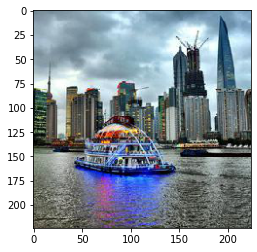

-----------------------------------------------------------------------
most similar products:


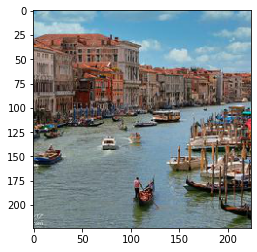

similarity score :  0.70439935


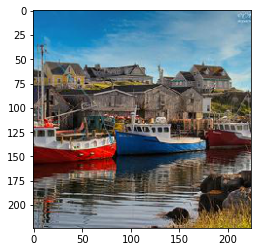

similarity score :  0.6598035


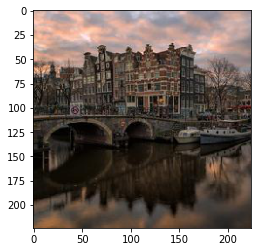

similarity score :  0.6205635


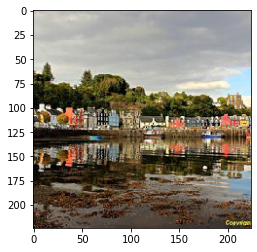

similarity score :  0.61306757


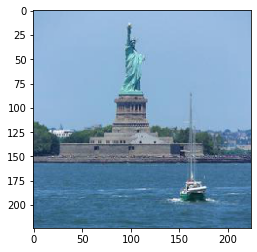

similarity score :  0.60631436


In [ ]:
retrieve_most_similar_products(files[56])

-----------------------------------------------------------------------
original product:


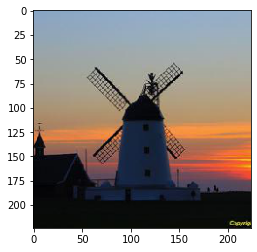

-----------------------------------------------------------------------
most similar products:


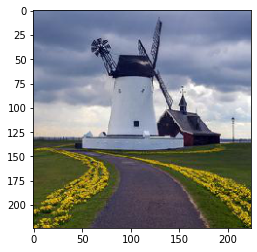

similarity score :  0.67398596


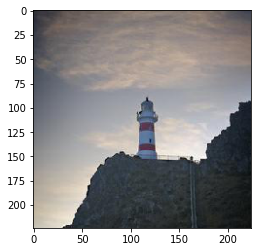

similarity score :  0.59961855


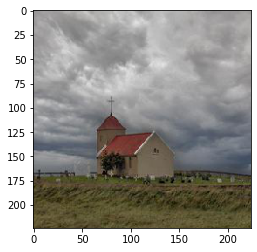

similarity score :  0.58635354


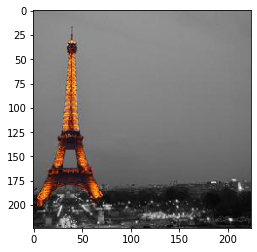

similarity score :  0.57758415


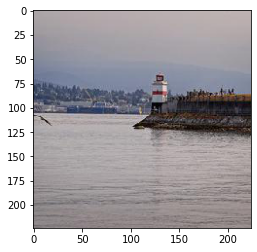

similarity score :  0.5691481


In [ ]:
retrieve_most_similar_products(files[92])

-----------------------------------------------------------------------
original product:


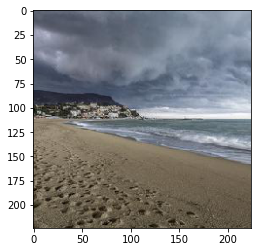

-----------------------------------------------------------------------
most similar products:


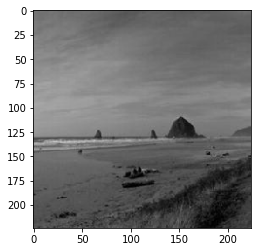

similarity score :  0.7217891


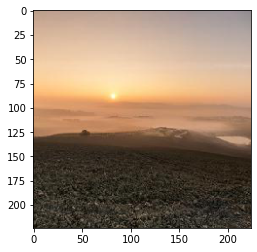

similarity score :  0.71936536


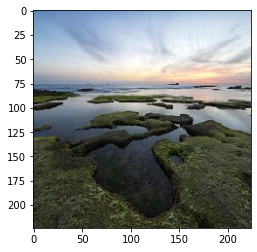

similarity score :  0.7169654


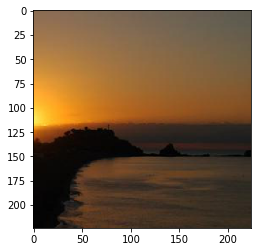

similarity score :  0.71334064


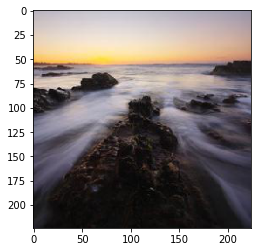

similarity score :  0.7125623


In [ ]:
retrieve_most_similar_products(files[135])

-----------------------------------------------------------------------
original product:


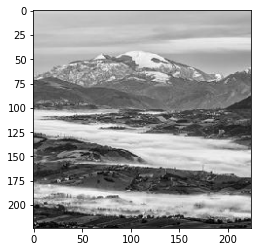

-----------------------------------------------------------------------
most similar products:


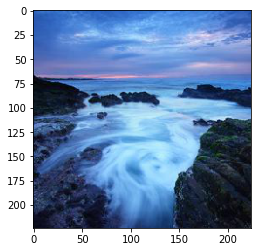

similarity score :  0.73288226


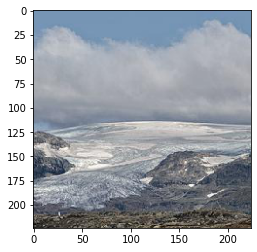

similarity score :  0.7286419


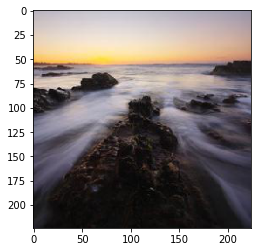

similarity score :  0.7213935


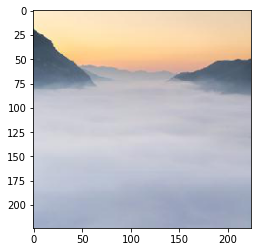

similarity score :  0.69863844


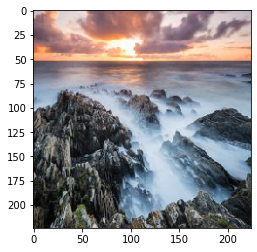

similarity score :  0.68229467


In [ ]:
retrieve_most_similar_products(files[433])

-----------------------------------------------------------------------
original product:


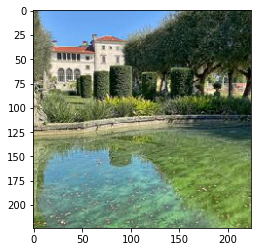

-----------------------------------------------------------------------
most similar products:


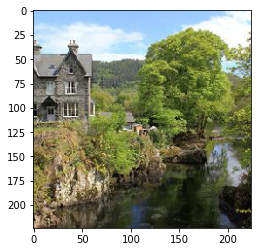

similarity score :  0.7481522


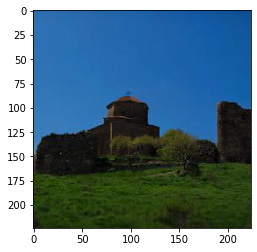

similarity score :  0.6543199


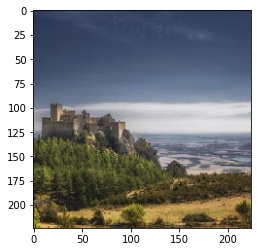

similarity score :  0.64836687


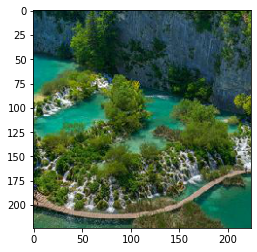

similarity score :  0.643492


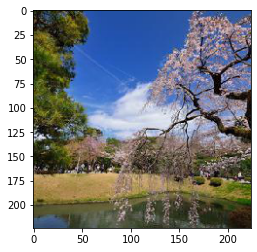

similarity score :  0.63471395


In [ ]:
retrieve_most_similar_products(files[400])

# Conclusion
We saw above that this very basic recommender system is able to find similar tourist  attraction accurately: most of the time the retrieved places look very similar.

This could be incorporated directly into a website using a web framework such as stramlit,Flask.

In [ ]:
import pickle
pickle.dump(cos_similarities_df,open('item_list.pkl','wb'))
pickle.dump(cosSimilarities,open('similarity.pkl','wb'))